### From SAV to LOVE

# HW №4  Семантическая сегментация semantsegmentation4

Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO     
Библиотеки: [Python, Tensorflow]  

### Подключение библиотек и скриптов

In [ ]:
# For local Jupyter Notebook 
from IPython.core.display import display, HTML, Image
display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# For Google Colaboratory
%tensorflow_version 2.x

In [ ]:
import time

import os
import skimage.io as io

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.rcParams.update({'font.size': 14})
pd.set_option('precision', 3)
pd.set_option('max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('max_colwidth', 300)

### Функция визуализации графиков

In [ ]:
def plot_model(history): 
    fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Accuracy of epochs')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epochs')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epochs')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

### Tensorflow with GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Paths to directories and files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Загрузка данных

In [ ]:
if 1:
    !mkdir -p data

    !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    !cd data && unzip -q train2017.zip
    !cd data && unzip -q val2017.zip
    !cd data && unzip -q annotations_trainval2017.zip

    !cd data && git clone https://github.com/cocodataset/cocoapi
    !cd data/cocoapi/PythonAPI && make

--2021-06-16 04:51:54--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.128.241
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.128.241|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  47.9MB/s    in 6m 35s  

2021-06-16 04:58:30 (46.6 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2021-06-16 04:58:30--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.10.4
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.10.4|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  45.4MB/s    in 17s     

2021-06-16 04:58:48 (44.5 MB/s) - ‘val

### Подготовка COCO API

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

### Универсальный класс Dataset для сегментации

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

### Класс для сегментационного датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=15.44s)
creating index...
index created!
loading annotations into memory...
Done (t=2.46s)
creating index...
index created!


### Создание пайплайна данных

In [ ]:
INP_SIZE = 256
NUM_EPOCHS = 1
BATCH_SIZE = 32

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
test_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

### Изучение датасета

In [ ]:
train_ds

<BatchDataset shapes: ((32, 256, 256, None), (32, 256, 256, None)), types: (tf.float32, tf.float32)>

In [ ]:
test_ds

<BatchDataset shapes: ((32, None, None, None), (32, None, None, None)), types: (tf.float32, tf.float32)>

In [ ]:
len(train_ds), len(test_ds)

(2003, 84)

### Визуализация датасета

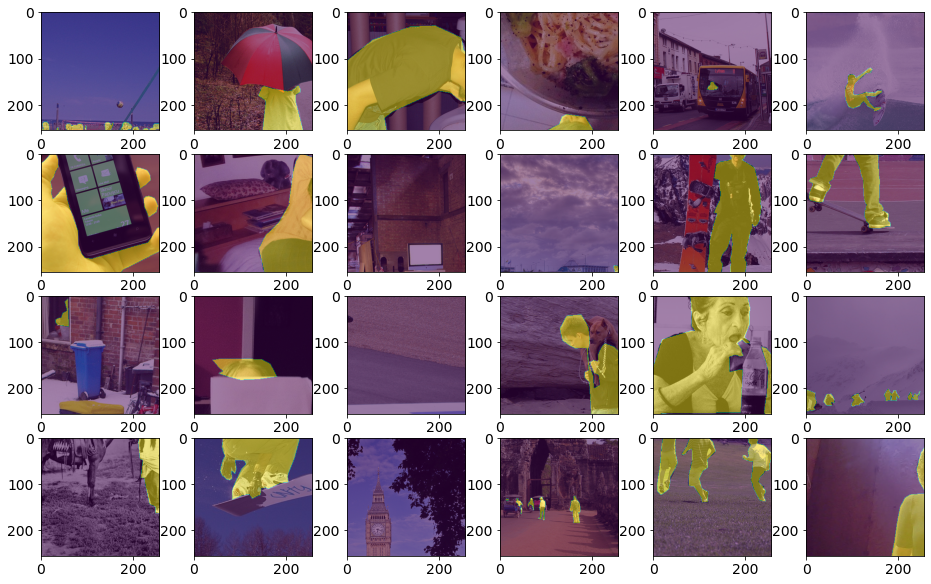

In [ ]:
image, mask = next(iter(train_ds.take(24)))

fig = plt.figure(figsize=(16, 10))
for i in range(24):
    ax = fig.add_subplot(4, 6, i+1)
    ax.imshow(image[i])
    ax.imshow(mask[i, ..., 0], alpha=0.5)
plt.show()

### Создание модели U-Net

In [ ]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model_un = build_model()

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model_un.compile(optimizer=optimizer,
              loss='BinaryCrossentropy', 
              metrics=['accuracy'])

In [ ]:
EXP_NAME = 'U-Net'

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+EXP_NAME, 
    write_graph=False, update_freq=100, profile_batch=0)

### Контрольные точки

In [ ]:
checkpoint_path = '/content/gdrive/MyDrive/Colab Notebooks/my_projects/checkpointV'

ckpt = tf.train.Checkpoint(
    model_un=model_un,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

### Обучение модели

In [ ]:
%%time
# start_time = time.time()

history_un = model_un.fit(train_ds, 
                          batch_size=BATCH_SIZE, 
                          epochs=1, 
                          validation_data=test_ds, 
                          callbacks=[tensorboard_callback]
                          )

ckpt_manager.save()

# model_time = (time.time() - start_time)

Epoch 1/5
2003/2003 [==============================] - 1567s 782ms/step - loss: 0.1687 - accuracy: 0.9310 - val_loss: 0.1850 - val_accuracy: 0.9235
Epoch 2/5
2003/2003 [==============================] - 1560s 779ms/step - loss: 0.1631 - accuracy: 0.9332 - val_loss: 0.1886 - val_accuracy: 0.9227
Epoch 3/5
2003/2003 [==============================] - 1567s 782ms/step - loss: 0.1603 - accuracy: 0.9348 - val_loss: 0.1844 - val_accuracy: 0.9248
Epoch 4/5
2003/2003 [==============================] - 1561s 779ms/step - loss: 0.1553 - accuracy: 0.9369 - val_loss: 0.1888 - val_accuracy: 0.9226
Epoch 5/5
2003/2003 [==============================] - 1561s 779ms/step - loss: 0.1515 - accuracy: 0.9385 - val_loss: 0.1804 - val_accuracy: 0.9270
CPU times: user 2h 2min 56s, sys: 5min 55s, total: 2h 8min 52s
Wall time: 2h 11min 10s


### Результат

In [ ]:
score_train_un = model_un.evaluate(train_ds, verbose=0)
score_test_un = model_un.evaluate(test_ds, verbose=0)

In [ ]:
result_un = pd.DataFrame((score_train_un[1], score_test_un[1], score_train_un[0], score_test_un[0])).T
result_un.columns=['train_accuracy', 'test_accuracy', 'train_loss', 'test_loss']
result_un['model'] = 'U-Net'

In [ ]:
result_un

,train_accuracy,test_accuracy,train_loss,test_loss,model
0,0.94154,0.92705,0.14460,0.18040,U-Net


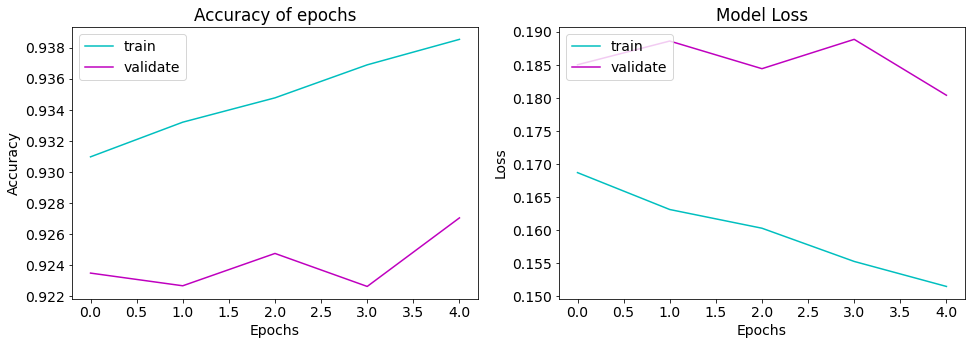

In [ ]:
plot_model(history_un)

### TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

### Запуск предсказания для случайного изображения

In [ ]:
import random

idx = random.randint(0, 100)

X_train, y_train = next(iter(train_ds.take(idx)))

In [ ]:
PERCEPTION = 0.5

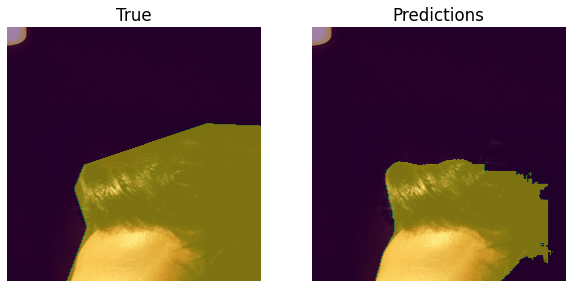

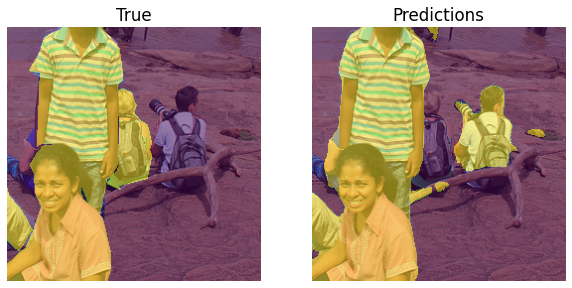

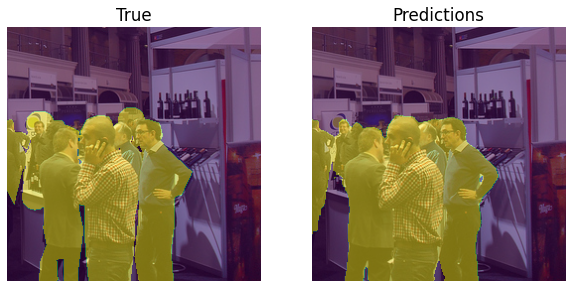

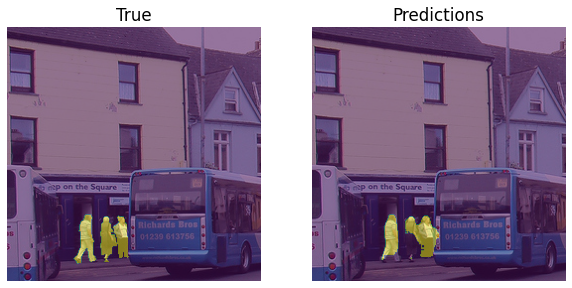

In [ ]:
pred_prob = model_un(X_train[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('True')
    plt.imshow(X_train[i])
    plt.imshow(y_train[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Predictions')
    plt.imshow(X_train[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

In [ ]:
idx = random.randint(0, 100)

X_test, y_test = next(iter(train_ds.take(idx)))

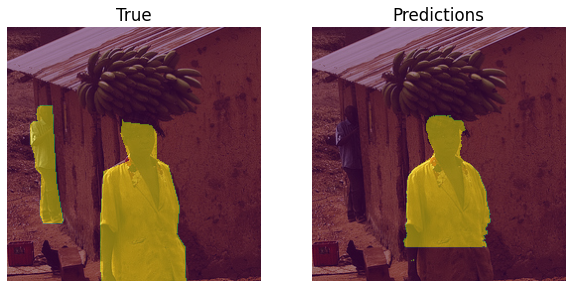

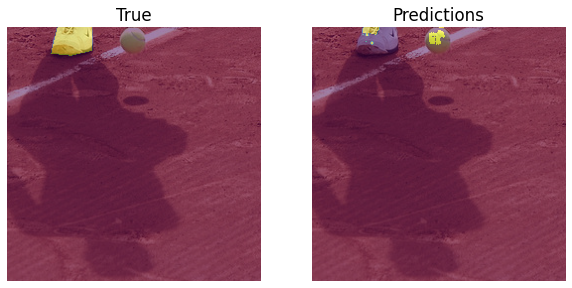

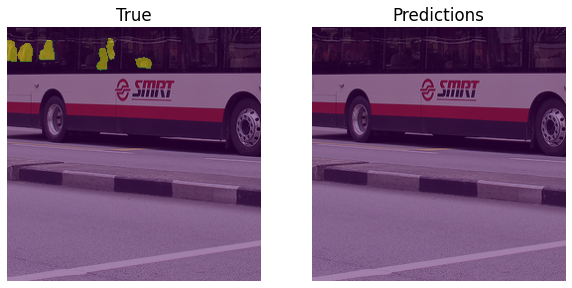

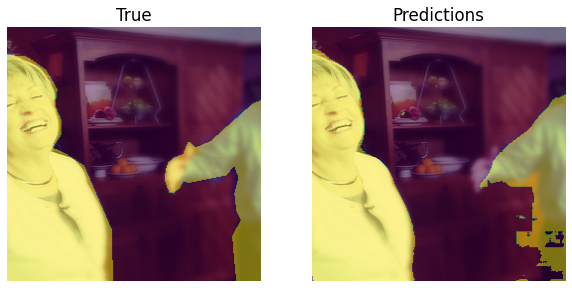

In [ ]:
pred_prob = model_un(X_test[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('True')
    plt.imshow(X_test[i])
    plt.imshow(y_test[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Predictions')
    plt.imshow(X_test[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')